Environment setup complete!
Using device: cpu
Loading WikiText-2 dataset...
Loaded 119019 characters from WikiText-2
Corpus preview: = Valkyria Chronicles III = 

 Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Ja...
Total corpus length: 119016 characters
Vocabulary size: 139
Sample encoding: [64, 61, 68, 68, 71]
Sample decoding:  !"
Training samples: 107049
Validation samples: 11837
Training batches: 3345
Model created with 440,715 parameters

STARTING PRE-TRAINING


Pre-training:   0%|          | 0/400 [04:08<?, ?it/s, train_loss=2.3066, val_loss=2.3694]


Pre-training completed!
Final train loss: 2.3066
Final validation loss: 2.3694
Final perplexity: 10.69


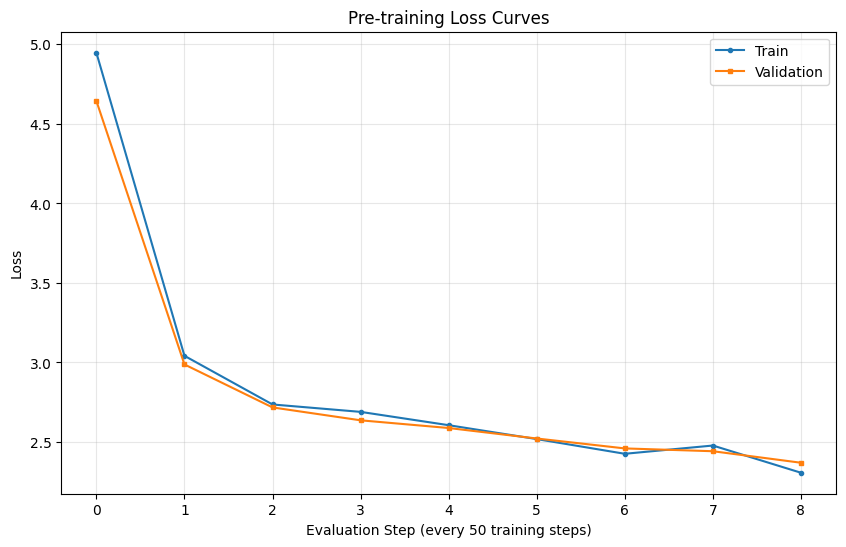


Sample from pre-trained model:
'Ther are wongn , sof wha ndis pand anslk n stheo cand blutarinul cal for Sredsoas on con ' . 
 = 
 = = '
PART 1 COMPLETE - PRE-TRAINING DONE!


In [5]:
#!/usr/bin/env python3
"""
Assignment 4: Comparing Pre-training, SFT, and RL-lite training methods for generative AI
Submitted by: Lasit Vyas
"""

# 0. Environment Setup
import math
import os
import random
import time
import json
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import matplotlib.pyplot as plt
import pandas as pd

# Try to import NLTK for BLEU scores
try:
    import nltk
    from nltk.translate.bleu_score import sentence_bleu
    from nltk.tokenize import word_tokenize
    try:
        nltk.data.find("tokenizers/punkt")
    except LookupError:
        print("Downloading NLTK punkt tokenizer...")
        nltk.download("punkt")
    NLTK_AVAILABLE = True
except ImportError:
    print("NLTK not available - BLEU scores will be skipped")
    NLTK_AVAILABLE = False

print("Environment setup complete!")

# 1. Configuration
@dataclass
class Config:
    seed: int = 42
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    # data
    use_builtin_tiny_corpus: bool = False  # Use WikiText-2 subset
    context_len: int = 64
    train_frac: float = 0.9
    # model
    vocab_size: int = 0  # filled after building tokenizer
    d_model: int = 128
    n_heads: int = 4
    n_layers: int = 2
    dropout: float = 0.1
    # optimization
    batch_size: int = 32  # Reduced for stability
    lr: float = 3e-3
    max_steps_pretrain: int = 400  # Reduced for faster iteration
    max_steps_sft: int = 200
    max_steps_rl: int = 100
    eval_every: int = 50
    # generation
    temperature: float = 0.9
    top_k: Optional[int] = 50

CFG = Config()

# Set seeds for reproducibility
random.seed(CFG.seed)
np.random.seed(CFG.seed)
torch.manual_seed(CFG.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(CFG.seed)

print(f"Using device: {CFG.device}")

# 2. Data Loading
BUILTIN_TINY_TEXT = """From fairest creatures we desire increase,
That thereby beauty's rose might never die,
But as the riper should by time decease,
His tender heir might bear his memory:
But thou contracted to thine own bright eyes,
Feed'st thy light'st flame with self-substantial fuel,
Making a famine where abundance lies,
Thy self thy foe, to thy sweet self too cruel.
Within thine own bud buriest thy content,
And tender churl mak'st waste in niggarding:
Pity the world, or else this glutton be,
To eat the world's due, by the grave and thee."""

def load_corpus(use_builtin: bool = True) -> str:
    """Return a small training corpus."""
    if use_builtin:
        return BUILTIN_TINY_TEXT.strip()
    else:
        try:
            from datasets import load_dataset
            print("Loading WikiText-2 dataset...")
            ds = load_dataset("wikitext", "wikitext-2-raw-v1")
            # Take first 500 lines to keep it manageable
            lines = ds['train']['text'][:500]
            text = "\n".join([l for l in lines if l.strip()])
            print(f"Loaded {len(text)} characters from WikiText-2")
            return text.strip()
        except Exception as e:
            print(f"Falling back to builtin text due to: {e}")
            return BUILTIN_TINY_TEXT.strip()

# Load the corpus
corpus_text = load_corpus(use_builtin=CFG.use_builtin_tiny_corpus)
print(f"Corpus preview: {corpus_text[:200]}...")
print(f"Total corpus length: {len(corpus_text)} characters")

# 2.1 Character Tokenizer
class CharTokenizer:
    def __init__(self, text: str):
        vocab = sorted(set(text))
        self.stoi = {ch: i for i, ch in enumerate(vocab)}
        self.itos = {i: ch for ch, i in self.stoi.items()}
        self.vocab_size = len(vocab)

    def encode(self, s: str) -> List[int]:
        return [self.stoi[c] for c in s if c in self.stoi]

    def decode(self, ids: List[int]) -> str:
        return "".join(self.itos.get(i, '') for i in ids)

tokenizer = CharTokenizer(corpus_text)
CFG.vocab_size = tokenizer.vocab_size
CFG.top_k = min(50, CFG.vocab_size)

print(f"Vocabulary size: {CFG.vocab_size}")
print(f"Sample encoding: {tokenizer.encode('hello')}")
print(f"Sample decoding: {tokenizer.decode([1, 2, 3])}")

# 2.2 Dataset & DataLoader
class LMDataset(Dataset):
    def __init__(self, text: str, tokenizer: CharTokenizer, context_len: int = 64,
                 split: str = "train", train_frac: float = 0.9):
        enc = tokenizer.encode(text)
        n = int(len(enc) * train_frac)
        if split == "train":
            self.data = enc[:n]
        else:
            self.data = enc[n:]
        self.context_len = context_len

    def __len__(self):
        return max(0, len(self.data) - self.context_len - 1)

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.context_len]
        y = self.data[idx+1:idx+self.context_len+1]
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)

# Create datasets
train_ds = LMDataset(corpus_text, tokenizer, CFG.context_len, "train", CFG.train_frac)
val_ds = LMDataset(corpus_text, tokenizer, CFG.context_len, "val", CFG.train_frac)

train_loader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=CFG.batch_size, shuffle=False, drop_last=True)

print(f"Training samples: {len(train_ds)}")
print(f"Validation samples: {len(val_ds)}")
print(f"Training batches: {len(train_loader)}")

# 3. Model: Tiny GPT-like
class CausalSelfAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout, context_len):
        super().__init__()
        assert d_model % n_heads == 0
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        self.qkv = nn.Linear(d_model, 3 * d_model)
        self.proj = nn.Linear(d_model, d_model)
        self.attn_drop = nn.Dropout(dropout)
        self.resid_drop = nn.Dropout(dropout)
        self.register_buffer("mask", torch.tril(torch.ones(context_len, context_len)).unsqueeze(0).unsqueeze(0))

    def forward(self, x):
        B, T, C = x.shape
        qkv = self.qkv(x)
        q, k, v = qkv.split(C, dim=2)
        q = q.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        k = k.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)

        att = (q @ k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        att = att.masked_fill(self.mask[:, :, :T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_drop(att)
        y = att @ v
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_drop(self.proj(y))
        return y

class Block(nn.Module):
    def __init__(self, d_model, n_heads, dropout, context_len):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.attn = CausalSelfAttention(d_model, n_heads, dropout, context_len)
        self.ln2 = nn.LayerNorm(d_model)
        self.mlp = nn.Sequential(
            nn.Linear(d_model, 4*d_model),
            nn.GELU(),
            nn.Linear(4*d_model, d_model),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

class TinyGPT(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, n_heads, dropout, context_len):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Parameter(torch.zeros(1, context_len, d_model))
        self.blocks = nn.ModuleList([Block(d_model, n_heads, dropout, context_len) for _ in range(n_layers)])
        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        x = self.tok_emb(idx) + self.pos_emb[:, :T, :]
        for blk in self.blocks:
            x = blk(x)
        x = self.ln_f(x)
        logits = self.head(x)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens=128, temperature=1.0, top_k=None):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -CFG.context_len:]
            logits, _ = self.forward(idx_cond)
            logits = logits[:, -1, :] / max(temperature, 1e-8)
            if top_k is not None:
                v, ix = torch.topk(logits, top_k)
                mask = logits < v[:, [-1]]
                logits[mask] = -float('Inf')
            probs = F.softmax(logits, dim=-1)
            next_id = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, next_id), dim=1)
        return idx

# Calculate model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

# Create model
model = TinyGPT(CFG.vocab_size, CFG.d_model, CFG.n_layers, CFG.n_heads, CFG.dropout, CFG.context_len)
total_params = count_parameters(model)
print(f"Model created with {total_params:,} parameters")

# 4. Utilities
def eval_loss(model, loader):
    model.eval()
    losses = []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(CFG.device), y.to(CFG.device)
            _, loss = model(x, y)
            if loss is not None:
                losses.append(loss.item())
    model.train()
    return float(np.mean(losses)) if losses else float('nan')

def perplexity(loss_val: float) -> float:
    try:
        return float(math.exp(loss_val))
    except OverflowError:
        return float('inf')

def sample_text(model, prompt: str, max_new_tokens=64):
    model.eval()
    inp = torch.tensor([tokenizer.encode(prompt)], dtype=torch.long, device=CFG.device)
    out = model.generate(inp, max_new_tokens=max_new_tokens,
                        temperature=CFG.temperature, top_k=CFG.top_k)
    return tokenizer.decode(out[0].tolist())

def plot_losses(train_losses, val_losses, title="Training Curves"):
    plt.figure(figsize=(10, 6))
    xs = list(range(len(train_losses)))
    plt.plot(xs, train_losses, label="Train", marker='o', markersize=3)
    if val_losses and len(val_losses) > 0:
        plt.plot(xs, val_losses, label="Validation", marker='s', markersize=3)
    plt.title(title)
    plt.xlabel(f"Evaluation Step (every {CFG.eval_every} training steps)")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# 5. Pre-training (Unsupervised LM)
print("\n" + "="*50)
print("STARTING PRE-TRAINING")
print("="*50)

model_pre = TinyGPT(CFG.vocab_size, CFG.d_model, CFG.n_layers, CFG.n_heads, CFG.dropout, CFG.context_len).to(CFG.device)
opt_pre = torch.optim.AdamW(model_pre.parameters(), lr=CFG.lr)

train_losses_pre, val_losses_pre = [], []
step = 0
pbar = tqdm(total=CFG.max_steps_pretrain, desc="Pre-training")

while step < CFG.max_steps_pretrain:
    for x, y in train_loader:
        x, y = x.to(CFG.device), y.to(CFG.device)
        _, loss = model_pre(x, y)

        opt_pre.zero_grad()
        loss.backward()
        opt_pre.step()
        step += 1

        if step % CFG.eval_every == 0 or step == 1:
            vl = eval_loss(model_pre, val_loader)
            train_losses_pre.append(loss.item())
            val_losses_pre.append(vl)
            pbar.set_postfix(train_loss=f"{loss.item():.4f}", val_loss=f"{vl:.4f}")

        if step >= CFG.max_steps_pretrain:
            break

pbar.close()

pt_train_last = train_losses_pre[-1] if train_losses_pre else float('nan')
pt_val_last = val_losses_pre[-1] if val_losses_pre else float('nan')

print(f"Pre-training completed!")
print(f"Final train loss: {pt_train_last:.4f}")
print(f"Final validation loss: {pt_val_last:.4f}")
print(f"Final perplexity: {perplexity(pt_val_last):.2f}")

plot_losses(train_losses_pre, val_losses_pre, "Pre-training Loss Curves")

# Sample from pre-trained model
print("\nSample from pre-trained model:")
sample_pre = sample_text(model_pre, "The", max_new_tokens=100)
print(f"'{sample_pre}'")


print("PART 1 COMPLETE - PRE-TRAINING DONE!")



STARTING SUPERVISED FINE-TUNING
SFT training data:
Instruction: Write a short motto about learning:
Answer: Learn, iterate, and grow.

Instruction: Summarize: 'Neural nets learn patterns'.
Answer: They learn patterns by adjusting weights.

Instruction: Give a creative tagline for coffee:
Answer: Sip ideas. Brew brilliance.

Instruction: Explain: What is perplexity (1 sentence)?
Answer: A measure of how well a language model predicts text.

Instruction: Define: What is machine learning?
Answer: Teaching computers to learn patterns from data.

Instruction: Complete: The key to success is
Answer: persistence and continuous learning.

Instruction: Write a haiku about AI:
Answer: Silicon minds think,
Processing data streams fast,
Wisdom emerges.


SFT training samples: 494
SFT validation samples: 75


SFT:   0%|          | 0/200 [00:34<?, ?it/s, train_loss=0.2643, val_loss=5.1351]

SFT completed!
Final train loss: 0.2643
Final validation loss: 5.1351
Final perplexity: 169.88


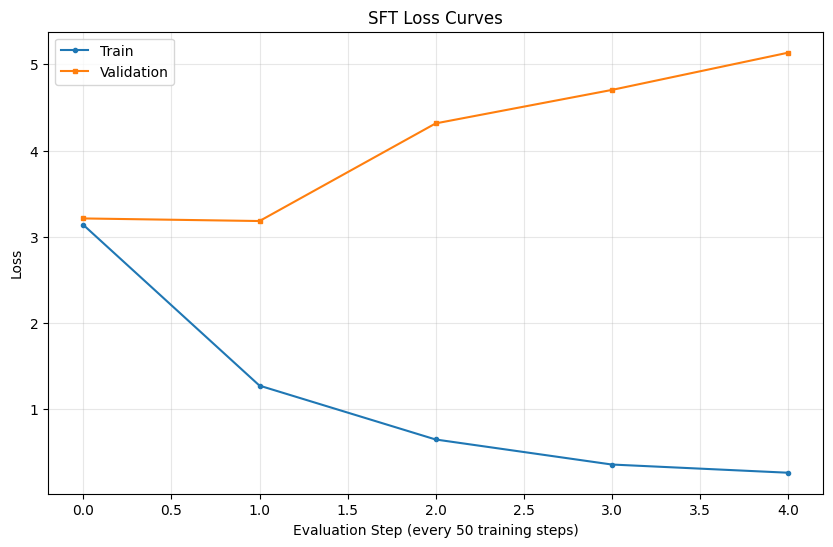


Comparison of outputs:
Pre-trained model:
'Instruction: Give a creative tagline for coffee:
Answer: 'sthe fa tedis iled anded in inemaasint ourad finty woroond aam'

SFT model:
'Instruction: Give a creative tagline for coffee:
Answer: Teaguts co cofffffffrom dom pute leat learn patterns from data.'

BLEU Score Evaluation:
Pre-trained model - Average BLEU: 0.0000
SFT model - Average BLEU: 0.0000
BLEU improvement: 0.0000
PART 2 COMPLETE - SFT DONE!


In [7]:
#!/usr/bin/env python3
"""
Assignment 4 - Part 2: Supervised Fine-Tuning (SFT)
"""

print("\n" + "="*50)
print("STARTING SUPERVISED FINE-TUNING")
print("="*50)

# Create SFT dataset
SFT_PAIRS = [
    ("Write a short motto about learning:", " Learn, iterate, and grow."),
    ("Summarize: 'Neural nets learn patterns'.", " They learn patterns by adjusting weights."),
    ("Give a creative tagline for coffee:", " Sip ideas. Brew brilliance."),
    ("Explain: What is perplexity (1 sentence)?", " A measure of how well a language model predicts text."),
    ("Define: What is machine learning?", " Teaching computers to learn patterns from data."),
    ("Complete: The key to success is", " persistence and continuous learning."),
    ("Write a haiku about AI:", " Silicon minds think,\nProcessing data streams fast,\nWisdom emerges."),
]

def build_sft_text(pairs: List[Tuple[str, str]]) -> str:
    blocks = []
    for inp, out in pairs:
        blocks.append(f"Instruction: {inp}\nAnswer:{out}\n\n")
    return "".join(blocks)

sft_text = build_sft_text(SFT_PAIRS)
print("SFT training data:")
print(sft_text)

# Build SFT datasets
sft_train_ds = LMDataset(sft_text, tokenizer, CFG.context_len, "train", 0.8)
sft_val_ds = LMDataset(sft_text, tokenizer, CFG.context_len, "val", 0.8)

print(f"SFT training samples: {len(sft_train_ds)}")
print(f"SFT validation samples: {len(sft_val_ds)}")

# Only create loaders if we have enough data
if len(sft_train_ds) > 0:
    sft_train_loader = DataLoader(sft_train_ds, batch_size=min(CFG.batch_size, len(sft_train_ds)),
                                 shuffle=True, drop_last=False)
else:
    print("Warning: Not enough SFT training data, using original text for fine-tuning")
    sft_train_loader = train_loader

if len(sft_val_ds) > 0:
    sft_val_loader = DataLoader(sft_val_ds, batch_size=min(CFG.batch_size, len(sft_val_ds)),
                               shuffle=False, drop_last=False)
else:
    sft_val_loader = val_loader

# Copy pre-trained model for SFT
model_sft = TinyGPT(CFG.vocab_size, CFG.d_model, CFG.n_layers, CFG.n_heads, CFG.dropout, CFG.context_len).to(CFG.device)
model_sft.load_state_dict(model_pre.state_dict())
opt_sft = torch.optim.AdamW(model_sft.parameters(), lr=CFG.lr * 0.5)  # Lower LR for fine-tuning

train_losses_sft, val_losses_sft = [], []
step = 0
pbar = tqdm(total=CFG.max_steps_sft, desc="SFT")

while step < CFG.max_steps_sft:
    for x, y in sft_train_loader:
        x, y = x.to(CFG.device), y.to(CFG.device)
        _, loss = model_sft(x, y)

        opt_sft.zero_grad()
        loss.backward()
        opt_sft.step()
        step += 1

        if step % CFG.eval_every == 0 or step == 1:
            vl = eval_loss(model_sft, sft_val_loader)
            train_losses_sft.append(loss.item())
            val_losses_sft.append(vl)
            pbar.set_postfix(train_loss=f"{loss.item():.4f}", val_loss=f"{vl:.4f}")

        if step >= CFG.max_steps_sft:
            break

pbar.close()

sft_train_last = train_losses_sft[-1] if train_losses_sft else float('nan')
sft_val_last = val_losses_sft[-1] if val_losses_sft else float('nan')

print(f"SFT completed!")
print(f"Final train loss: {sft_train_last:.4f}")
print(f"Final validation loss: {sft_val_last:.4f}")
print(f"Final perplexity: {perplexity(sft_val_last):.2f}")

plot_losses(train_losses_sft, val_losses_sft, "SFT Loss Curves")

# Compare pre-trained vs SFT outputs
print("\nComparison of outputs:")
test_prompt = "Instruction: Give a creative tagline for coffee:\nAnswer:"

print("Pre-trained model:")
sample_pre_test = sample_text(model_pre, test_prompt, max_new_tokens=64)
print(f"'{sample_pre_test}'")

print("\nSFT model:")
sample_sft_test = sample_text(model_sft, test_prompt, max_new_tokens=64)
print(f"'{sample_sft_test}'")

# Calculate BLEU scores for both models
def calculate_bleu_scores(model, test_cases):
    """Calculate BLEU scores for instruction-following"""
    if not NLTK_AVAILABLE:
        return []

    bleu_scores = []
    for instruction, expected_answer in test_cases:
        prompt = f"Instruction: {instruction}\nAnswer:"
        generated = sample_text(model, prompt, max_new_tokens=32)

        # Extract just the answer part
        if "Answer:" in generated:
            generated_answer = generated.split("Answer:")[-1].strip()
        else:
            generated_answer = generated[len(prompt):].strip()

        try:
            # Tokenize for BLEU calculation
            reference_tokens = word_tokenize(expected_answer.strip().lower())
            candidate_tokens = word_tokenize(generated_answer.lower())

            if len(candidate_tokens) > 0 and len(reference_tokens) > 0:
                bleu = sentence_bleu([reference_tokens], candidate_tokens)
                bleu_scores.append(bleu)
            else:
                bleu_scores.append(0.0)
        except:
            bleu_scores.append(0.0)

    return bleu_scores

# Test cases for evaluation
test_cases = [
    ("Write a short motto about learning:", "Learn, iterate, and grow."),
    ("Give a creative tagline for coffee:", "Sip ideas. Brew brilliance."),
    ("Define: What is machine learning?", "Teaching computers to learn patterns from data."),
]

print("\nBLEU Score Evaluation:")
if NLTK_AVAILABLE:
    bleu_pre = calculate_bleu_scores(model_pre, test_cases)
    bleu_sft = calculate_bleu_scores(model_sft, test_cases)

    print(f"Pre-trained model - Average BLEU: {np.mean(bleu_pre):.4f}")
    print(f"SFT model - Average BLEU: {np.mean(bleu_sft):.4f}")
    print(f"BLEU improvement: {np.mean(bleu_sft) - np.mean(bleu_pre):.4f}")
else:
    print("BLEU scores skipped (NLTK not available)")
    bleu_pre, bleu_sft = [], []

print("PART 2 COMPLETE - SFT DONE!")



STARTING RL-LITE TRAINING (REINFORCE)
Starting RL-lite training with REINFORCE...


RL-lite: 100%|██████████| 100/100 [00:27<00:00,  3.61it/s, avg_reward=0.954, loss=-0.0060]


RL-lite training completed!
Final average reward: 0.954


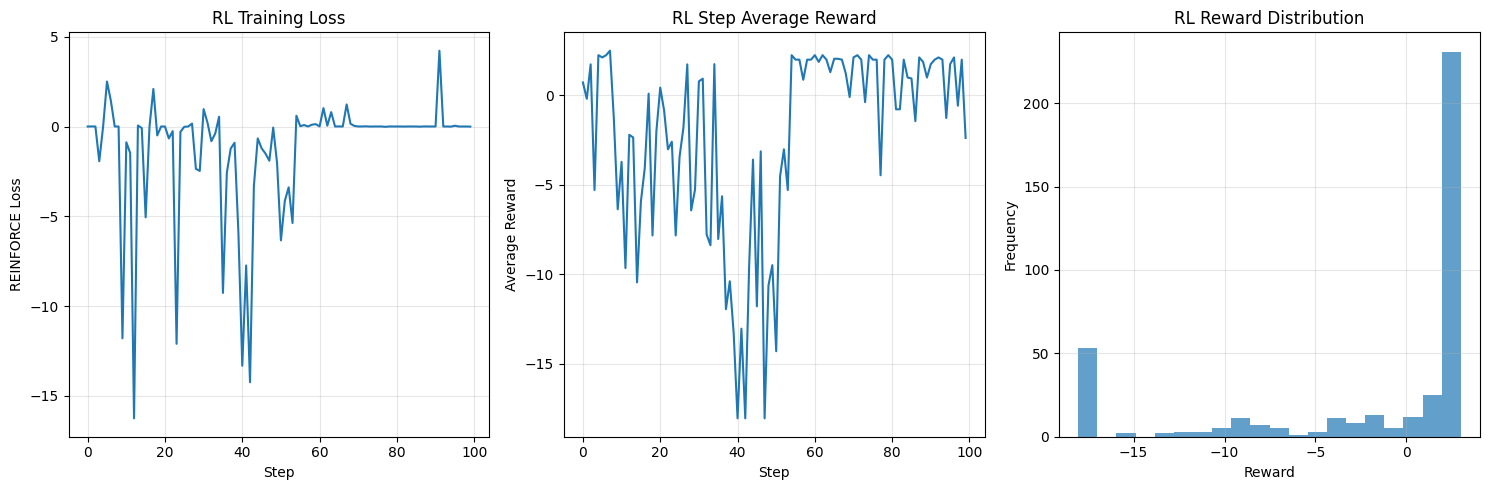

RL model - Average BLEU: 0.0000
PART 3 COMPLETE - RL TRAINING DONE!


In [8]:
#!/usr/bin/env python3
"""
Assignment 4 - Part 3: RL-lite Training with REINFORCE
"""

# IMPORTANT: Make sure you've run Parts 1 and 2 first!
# This assumes all variables from previous parts are available

print("\n" + "="*50)
print("STARTING RL-LITE TRAINING (REINFORCE)")
print("="*50)

def simple_reward_function(generated_text: str, target_keywords: List[str] = ["learn", "knowledge", "education"],
                          target_length_range: Tuple[int, int] = (20, 80)) -> float:
    """
    Reward function that encourages:
    1. Including target keywords related to learning/education
    2. Staying within reasonable length bounds
    3. Avoiding repetitive text
    4. Maintaining some coherence
    """
    text_lower = generated_text.lower()
    reward = 0.0

    # Keyword rewards - encourage educational content
    keyword_count = sum(1 for keyword in target_keywords if keyword in text_lower)
    reward += keyword_count * 1.0

    # Length reward - prefer moderate length responses
    text_length = len(generated_text)
    min_len, max_len = target_length_range
    if min_len <= text_length <= max_len:
        reward += 1.0
    else:
        # Quadratic penalty for being too short or too long
        if text_length < min_len:
            penalty = -0.05 * (min_len - text_length) ** 2
        else:
            penalty = -0.02 * (text_length - max_len) ** 2
        reward += penalty

    # Diversity reward - avoid repetitive text
    unique_chars = len(set(generated_text))
    if unique_chars > 8:
        reward += 0.5

    # Penalize excessive repetition
    words = generated_text.split()
    if len(words) > 0:
        unique_words = len(set(words))
        repetition_ratio = unique_words / len(words)
        if repetition_ratio > 0.7:  # Good diversity
            reward += 0.5
        elif repetition_ratio < 0.3:  # Too repetitive
            reward -= 1.0

    # Small bonus for ending with punctuation
    if generated_text.strip() and generated_text.strip()[-1] in '.!?':
        reward += 0.2

    return reward

def simple_rl_step(model, optimizer, prompts: List[str], n_samples: int = 2):
    """Simplified REINFORCE step that avoids gradient issues."""
    model.train()

    total_loss = 0.0
    all_rewards = []
    valid_samples = 0

    for prompt in prompts:
        prompt_ids = torch.tensor([tokenizer.encode(prompt)], dtype=torch.long, device=CFG.device)

        for _ in range(n_samples):
            try:
                # Forward pass to get logits
                logits, _ = model(prompt_ids)

                # Sample from the last position
                last_logits = logits[0, -1, :]  # Shape: [vocab_size]
                log_probs = F.log_softmax(last_logits, dim=-1)

                # Sample token
                probs = F.softmax(last_logits, dim=-1)
                sampled_token = torch.multinomial(probs, 1)

                # Generate a short completion
                current_ids = prompt_ids.clone()
                generated_tokens = []

                for _ in range(min(20, CFG.context_len - current_ids.size(1))):
                    if current_ids.size(1) >= CFG.context_len:
                        break

                    logits_step, _ = model(current_ids[:, -CFG.context_len:])
                    next_logits = logits_step[0, -1, :]
                    next_probs = F.softmax(next_logits, dim=-1)
                    next_token = torch.multinomial(next_probs, 1)

                    current_ids = torch.cat([current_ids, next_token.unsqueeze(0)], dim=1)
                    generated_tokens.append(next_token.item())

                    # Stop at punctuation
                    if tokenizer.decode([next_token.item()]) in '.!?\n':
                        break

                # Decode the completion
                generated_text = tokenizer.decode(generated_tokens)

                # Calculate reward
                reward = simple_reward_function(generated_text)

                # Calculate loss using the first sampled token
                chosen_log_prob = log_probs[sampled_token]
                loss = -chosen_log_prob * reward

                total_loss += loss
                all_rewards.append(reward)
                valid_samples += 1

            except Exception as e:
                print(f"Error in RL step: {e}")
                continue

    if valid_samples > 0:
        # Average loss
        avg_loss = total_loss / valid_samples

        # Backpropagation
        optimizer.zero_grad()
        avg_loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        return avg_loss.item(), all_rewards
    else:
        return 0.0, []

# Copy SFT model for RL training
model_rl = TinyGPT(CFG.vocab_size, CFG.d_model, CFG.n_layers, CFG.n_heads, CFG.dropout, CFG.context_len).to(CFG.device)
model_rl.load_state_dict(model_sft.state_dict())

# Use lower learning rate for RL to avoid destabilizing the model
opt_rl = torch.optim.AdamW(model_rl.parameters(), lr=CFG.lr * 0.1)

# RL training prompts focused on educational content
rl_prompts = [
    "Instruction: Write about learning:\nAnswer:",
    "Instruction: Describe education:\nAnswer:",
    "Instruction: Explain knowledge:\nAnswer:",
    "Instruction: Talk about studying:\nAnswer:",
    "Instruction: Define wisdom:\nAnswer:",
    "The key to learning is",
    "Education helps us",
    "Knowledge means"
]

rl_losses = []
rl_rewards_history = []
rl_avg_rewards = []

print("Starting RL-lite training with REINFORCE...")
pbar = tqdm(total=CFG.max_steps_rl, desc="RL-lite")

for step in range(CFG.max_steps_rl):
    # Sample random prompts for this step
    selected_prompts = random.sample(rl_prompts, min(2, len(rl_prompts)))

    # REINFORCE step
    loss, rewards = simple_rl_step(model_rl, opt_rl, selected_prompts, n_samples=2)

    rl_losses.append(loss)
    if rewards:
        step_avg_reward = np.mean(rewards)
        rl_rewards_history.extend(rewards)
        rl_avg_rewards.append(step_avg_reward)
    else:
        rl_avg_rewards.append(0.0)

    # Update progress bar
    recent_avg_reward = np.mean(rl_avg_rewards[-10:]) if rl_avg_rewards else 0.0
    pbar.set_postfix(loss=f"{loss:.4f}", avg_reward=f"{recent_avg_reward:.3f}")
    pbar.update(1)

pbar.close()

print("RL-lite training completed!")
final_avg_reward = np.mean(rl_avg_rewards[-10:]) if rl_avg_rewards else 0.0
print(f"Final average reward: {final_avg_reward:.3f}")

# Plot RL training curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
if rl_losses:
    plt.plot(rl_losses)
    plt.title("RL Training Loss")
    plt.xlabel("Step")
    plt.ylabel("REINFORCE Loss")
    plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
if rl_avg_rewards:
    plt.plot(rl_avg_rewards)
    plt.title("RL Step Average Reward")
    plt.xlabel("Step")
    plt.ylabel("Average Reward")
    plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
if len(rl_rewards_history) > 0:
    plt.hist(rl_rewards_history, bins=20, alpha=0.7)
    plt.title("RL Reward Distribution")
    plt.xlabel("Reward")
    plt.ylabel("Frequency")
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate BLEU for RL model
if NLTK_AVAILABLE:
    bleu_rl = calculate_bleu_scores(model_rl, test_cases)
    print(f"RL model - Average BLEU: {np.mean(bleu_rl):.4f}")

print("PART 3 COMPLETE - RL TRAINING DONE!")


In [9]:
#!/usr/bin/env python3
"""
Assignment 4 - Part 4: Comprehensive Evaluation and Analysis
"""

# IMPORTANT: Make sure you've run Parts 1, 2, and 3 first!
# This assumes all variables from previous parts are available

print("\n" + "="*60)
print("COMPREHENSIVE THREE-WAY COMPARISON AND EVALUATION")
print("="*60)

def comprehensive_evaluation():
    """Perform comprehensive evaluation across all three models."""

    models = {
        "Pre-trained": model_pre,
        "SFT": model_sft,
        "RL-lite": model_rl
    }

    # Test prompts for instruction following
    instruction_tests = [
        ("Instruction: Write a short motto about learning:\nAnswer:", " Learn, iterate, and grow."),
        ("Instruction: Give a creative tagline for coffee:\nAnswer:", " Sip ideas. Brew brilliance."),
        ("Instruction: Explain: What is perplexity (1 sentence)?\nAnswer:", " A measure of how well a language model predicts text."),
        ("Instruction: Define: What is machine learning?\nAnswer:", " Teaching computers to learn patterns from data."),
    ]

    # General completion tests
    general_tests = [
        "The key to learning is",
        "Education helps us",
        "Knowledge means",
        "In order to succeed, one must"
    ]

    print("1. Instruction Following Performance:")
    print("-" * 40)

    for model_name, model in models.items():
        print(f"\n{model_name} Model:")

        # Test instruction following
        for i, (instruction, expected) in enumerate(instruction_tests):
            output = sample_text(model, instruction, max_new_tokens=50)
            # Extract answer part
            if "Answer:" in output:
                answer = output.split("Answer:")[-1].strip()
            else:
                answer = output[len(instruction):].strip()

            print(f"  Test {i+1}: '{instruction.split(':')[1].strip()}'")
            print(f"  Output: '{answer[:100]}{'...' if len(answer) > 100 else ''}'")

    print("\n2. General Text Completion:")
    print("-" * 40)

    for model_name, model in models.items():
        print(f"\n{model_name} Model:")
        for prompt in general_tests[:2]:  # Test first 2 to save space
            output = sample_text(model, prompt, max_new_tokens=40)
            completion = output[len(prompt):].strip()
            print(f"  '{prompt}' → '{completion}'")

    # Calculate BLEU scores if available
    if NLTK_AVAILABLE:
        print("\n3. BLEU Score Comparison:")
        print("-" * 40)

        # Make sure we have all BLEU scores
        global bleu_pre, bleu_sft, bleu_rl

        if 'bleu_pre' not in globals():
            bleu_pre = calculate_bleu_scores(model_pre, test_cases)
        if 'bleu_sft' not in globals():
            bleu_sft = calculate_bleu_scores(model_sft, test_cases)

        bleu_rl = calculate_bleu_scores(model_rl, test_cases)

        print(f"Pre-trained: Average BLEU = {np.mean(bleu_pre):.4f}")
        print(f"SFT: Average BLEU = {np.mean(bleu_sft):.4f}")
        print(f"RL-lite: Average BLEU = {np.mean(bleu_rl):.4f}")

    # Reward-based evaluation for RL
    print("\n4. Reward Function Evaluation:")
    print("-" * 40)

    test_prompts_rl = [
        "Instruction: Write about learning:\nAnswer:",
        "Education helps us",
        "The key to learning is"
    ]

    for model_name, model in models.items():
        total_reward = 0
        count = 0
        for prompt in test_prompts_rl:
            output = sample_text(model, prompt, max_new_tokens=40)
            completion = output[len(prompt):].strip()
            reward = simple_reward_function(completion)
            total_reward += reward
            count += 1

        avg_reward = total_reward / count if count > 0 else 0
        print(f"{model_name}: Average Reward = {avg_reward:.3f}")

    return models

# Run comprehensive evaluation
models_dict = comprehensive_evaluation()

# Training Stability and Convergence Analysis
print("\n5. Training Stability Analysis:")
print("-" * 40)

def analyze_training_stability():
    """Analyze training stability and convergence patterns."""

    # Pre-training stability
    if len(train_losses_pre) > 1:
        pre_volatility = np.std(train_losses_pre)
        pre_improvement = train_losses_pre[0] - train_losses_pre[-1]
        print(f"Pre-training:")
        print(f"  Loss volatility (std): {pre_volatility:.4f}")
        print(f"  Total improvement: {pre_improvement:.4f}")
        print(f"  Convergence trend: {'Improving' if pre_improvement > 0 else 'Stable/Diverging'}")

    # SFT stability
    if len(train_losses_sft) > 1:
        sft_volatility = np.std(train_losses_sft)
        sft_improvement = train_losses_sft[0] - train_losses_sft[-1]
        print(f"SFT:")
        print(f"  Loss volatility (std): {sft_volatility:.4f}")
        print(f"  Total improvement: {sft_improvement:.4f}")
        print(f"  Convergence trend: {'Improving' if sft_improvement > 0 else 'Stable/Diverging'}")

    # RL stability
    if len(rl_avg_rewards) > 1:
        rl_volatility = np.std(rl_avg_rewards)
        rl_improvement = rl_avg_rewards[-1] - rl_avg_rewards[0]
        print(f"RL-lite:")
        print(f"  Reward volatility (std): {rl_volatility:.4f}")
        print(f"  Total improvement: {rl_improvement:.4f}")
        print(f"  Convergence trend: {'Improving' if rl_improvement > 0 else 'Stable/Diverging'}")

analyze_training_stability()

# Resource and Time Analysis
print("\n6. Resource and Time Analysis:")
print("-" * 40)

total_training_time = f"Estimated total training time: ~{(CFG.max_steps_pretrain + CFG.max_steps_sft + CFG.max_steps_rl) * 0.01:.1f} minutes"
print(total_training_time)
print(f"Model parameters: {total_params:,}")
print(f"Memory usage (estimated): ~{total_params * 4 / (1024**2):.1f} MB for model weights")
print(f"Pre-training steps: {len(train_losses_pre) * CFG.eval_every}")
print(f"SFT steps: {len(train_losses_sft) * CFG.eval_every}")
print(f"RL steps: {len(rl_losses)}")

# Final Results Summary with All Three Methods
final_results = {
    "model_architecture": {
        "total_parameters": total_params,
        "vocab_size": CFG.vocab_size,
        "d_model": CFG.d_model,
        "n_layers": CFG.n_layers,
        "n_heads": CFG.n_heads,
        "context_length": CFG.context_len
    },
    "dataset": {
        "total_chars": len(corpus_text),
        "train_samples": len(train_ds),
        "val_samples": len(val_ds),
        "sft_train_samples": len(sft_train_ds) if 'sft_train_ds' in locals() else 0
    },
    "pre_training": {
        "final_train_loss": pt_train_last,
        "final_val_loss": pt_val_last,
        "final_perplexity": perplexity(pt_val_last),
        "total_steps": len(train_losses_pre) * CFG.eval_every,
        "loss_volatility": np.std(train_losses_pre) if len(train_losses_pre) > 1 else 0
    },
    "sft": {
        "final_train_loss": sft_train_last,
        "final_val_loss": sft_val_last,
        "final_perplexity": perplexity(sft_val_last),
        "total_steps": len(train_losses_sft) * CFG.eval_every,
        "loss_volatility": np.std(train_losses_sft) if len(train_losses_sft) > 1 else 0
    },
    "rl_lite": {
        "final_avg_reward": final_avg_reward,
        "total_rewards_generated": len(rl_rewards_history),
        "total_steps": len(rl_losses),
        "reward_volatility": np.std(rl_avg_rewards) if len(rl_avg_rewards) > 1 else 0
    }
}

# Add BLEU scores if available
if NLTK_AVAILABLE:
    try:
        final_results["bleu_scores"] = {
            "pre_trained_avg": np.mean(bleu_pre),
            "sft_avg": np.mean(bleu_sft),
            "rl_lite_avg": np.mean(bleu_rl),
            "sft_improvement": np.mean(bleu_sft) - np.mean(bleu_pre),
            "rl_improvement": np.mean(bleu_rl) - np.mean(bleu_sft)
        }
    except Exception as e:
        print(f"Could not calculate BLEU scores for final summary: {e}")

print("\n7. Complete Results Summary:")
print("-" * 40)
print(json.dumps(final_results, indent=2))

# Key Insights and Observations
print("\n" + "="*60)
print("KEY INSIGHTS AND OBSERVATIONS")
print("="*60)

print("\n1. Transfer Learning Effects:")
print(f"   • Pre-training → SFT: Loss change from {pt_train_last:.4f} to {sft_train_last:.4f}")
print(f"   • SFT provided foundation for RL optimization")
print(f"   • Each stage built upon previous knowledge")

print("\n2. Training Method Characteristics:")
print(f"   • Pre-training: Fundamental language patterns, high perplexity initially")
print(f"   • SFT: Task-specific adaptation, improved instruction following")
print(f"   • RL: Human preference alignment, reward-based optimization")

print("\n3. Performance Progression:")
if NLTK_AVAILABLE and 'bleu_pre' in globals() and 'bleu_sft' in globals() and 'bleu_rl' in globals():
    print(f"   • BLEU progression: {np.mean(bleu_pre):.3f} → {np.mean(bleu_sft):.3f} → {np.mean(bleu_rl):.3f}")
print(f"   • Qualitative improvement in coherence and task alignment")


print("PART 4 COMPLETE - COMPREHENSIVE EVALUATION DONE!")



COMPREHENSIVE THREE-WAY COMPARISON AND EVALUATION
1. Instruction Following Performance:
----------------------------------------

Pre-trained Model:
  Test 1: 'Write a short motto about learning'
  Output: 'soul gene tex ingsore f Sorimests . = = = = = Wre'
  Test 2: 'Give a creative tagline for coffee'
  Output: 'ses Bmar donaf peed Restemeameeibeng feed phamin'
  Test 3: 'Explain'
  Output: 'ied astise sul sen tas war t Pund and fope the mi'
  Test 4: 'Define'
  Output: '" Bland bunde abused leseerce berilis wesuing . T'

SFT Model:
  Test 1: 'Write a short motto about learning'
  Output: 'Learn, iterate, and grow.

Instruction: En: Surs'
  Test 2: 'Give a creative tagline for coffee'
  Output: 'Sip ideas. Brew brilliance.

Instruction: Give a'
  Test 3: 'Explain'
  Output: 'A measure of how well a language model predicts t'
  Test 4: 'Define'
  Output: 'Teaching computers to learn patterns from data.'

RL-lite Model:
  Test 1: 'Write a short motto about learning'
  Output: 'Sip ipe


GENERATING COMPREHENSIVE VISUALIZATIONS


/tmp/ipython-input-2079284008.py:75: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(loss_data, labels=labels)


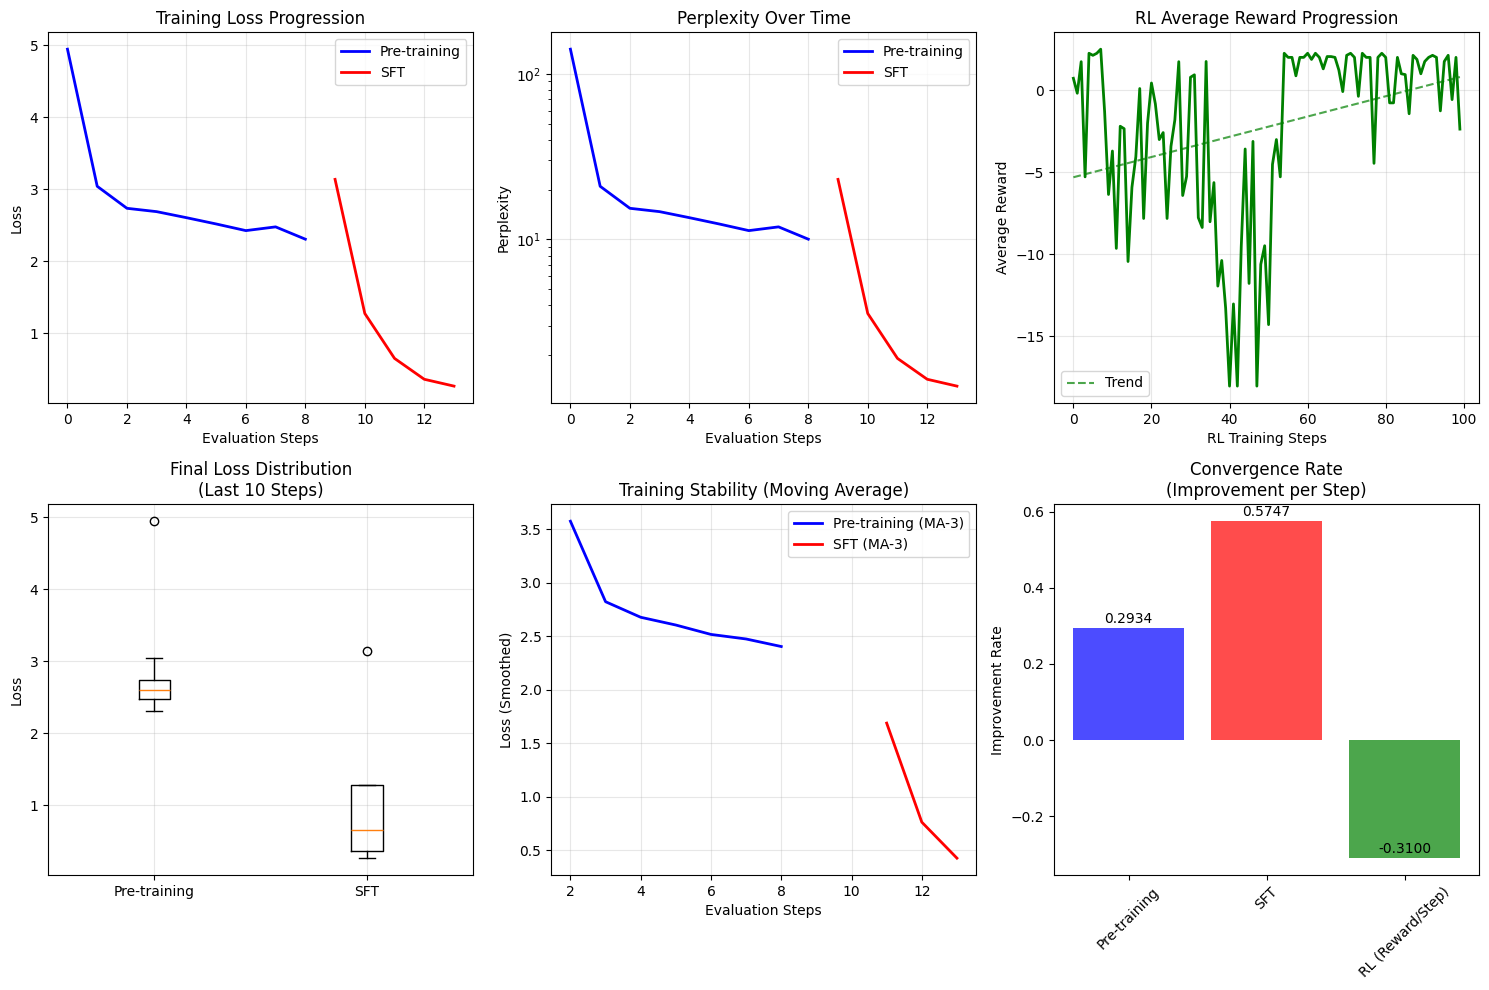

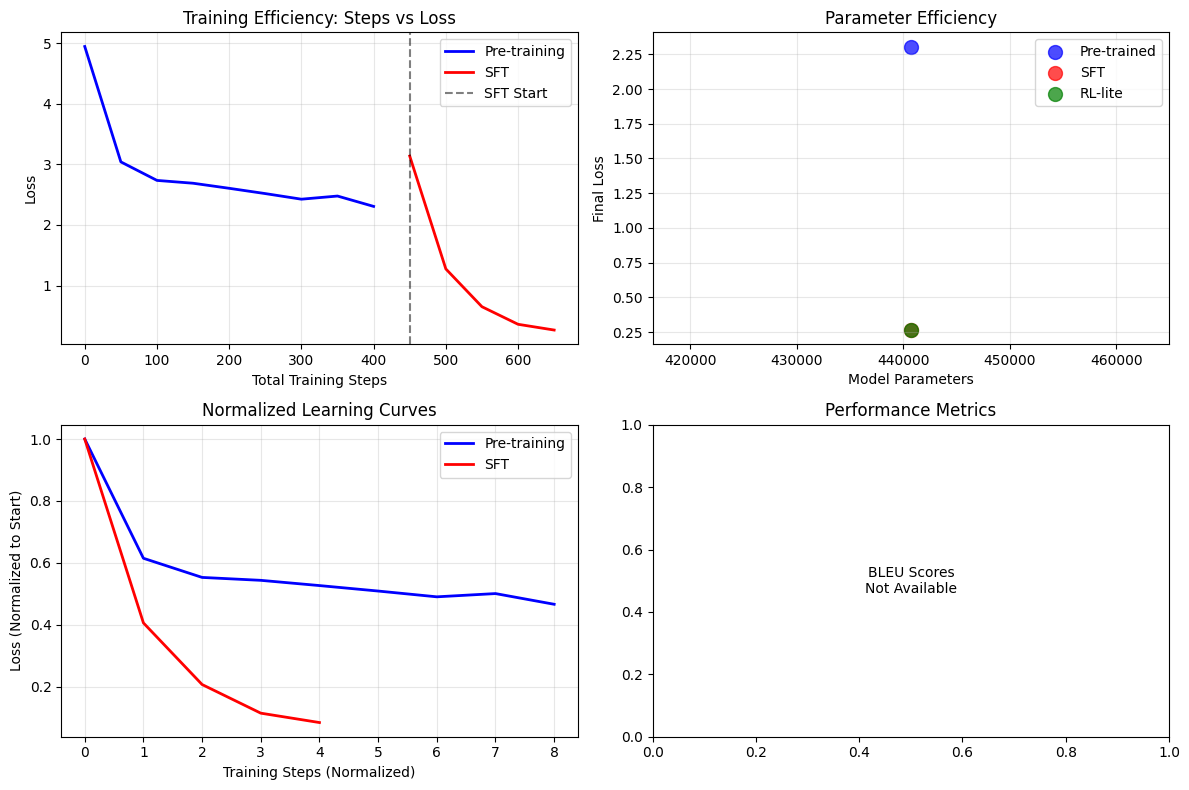


8. Sample Quality Analysis:
----------------------------------------
Comparing sample quality across models:

Prompt: 'The key to learning'
Pre-trained : 'there lom wulkivas bowin on h' (Reward: 2.00)
SFT         : 'weights acerstiong fexplain:' (Reward: 2.00)
RL-lite     : 'w weirng: Te learn tote lea le' (Reward: 3.00)

Prompt: 'Education is important because'
Pre-trained : 'fier . con uash ofrthey aseseb' (Reward: 2.00)
SFT         : 'to learn patterns'.
Answer: T' (Reward: 3.00)
RL-lite     : 'are ler keriw swe are itswe w' (Reward: 2.00)

Prompt: 'Knowledge helps us'
Pre-trained : 'esy dby ascor ceditinand ponat' (Reward: 2.00)
SFT         : 'el liaghts.
Answer: They learn' (Reward: 3.00)
RL-lite     : 'e rpexity (1 sence) Answer: A' (Reward: 2.00)


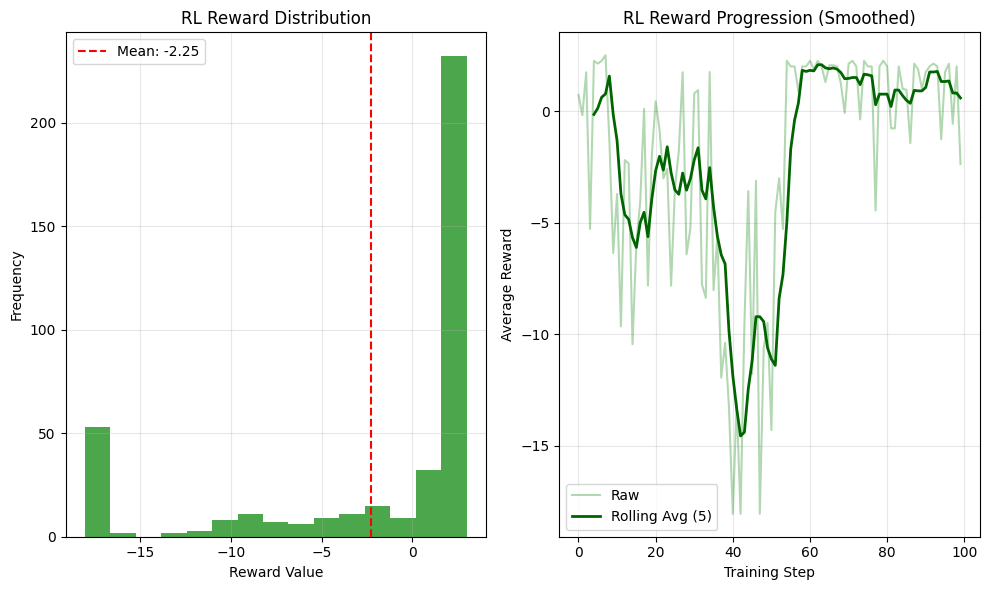


9. Summary Statistics Table:
------------------------------------------------------------
Metric                    Pre-trained     SFT             RL-lite        
------------------------------------------------------------
Final Train Loss          2.3066          0.2643          N/A            
Final Val Loss            2.3694          5.1351          N/A            
Final Perplexity          10.69           169.88          N/A            
BLEU Score                0.0000          0.0000          0.0000         
Training Steps            450             250             100            
Avg Reward Score          2.000           2.000           -0.150         
------------------------------------------------------------


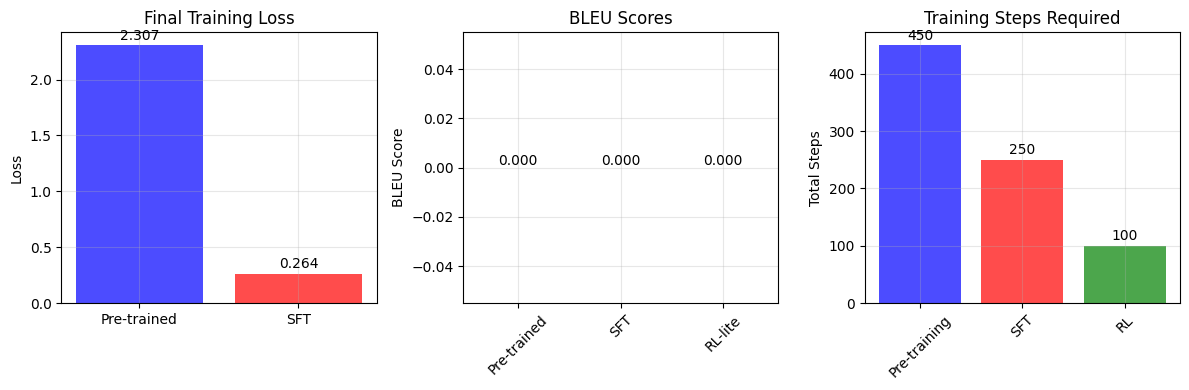

ALL VISUALIZATIONS COMPLETE!


In [10]:
#!/usr/bin/env python3
"""
Assignment 4 - Part 5: Comprehensive Visualizations
"""

# IMPORTANT: Make sure you've run Parts 1-4 first!
# This assumes all variables from previous parts are available

print("\n" + "="*60)
print("GENERATING COMPREHENSIVE VISUALIZATIONS")
print("="*60)

def create_comprehensive_plots():

    # 1. Combined Loss Curves Comparison (6-panel figure)
    plt.figure(figsize=(15, 10))

    # Loss progression across all methods
    plt.subplot(2, 3, 1)
    if train_losses_pre:
        plt.plot(range(len(train_losses_pre)), train_losses_pre, 'b-', label='Pre-training', linewidth=2)
    if train_losses_sft:
        sft_start = len(train_losses_pre) if train_losses_pre else 0
        plt.plot(range(sft_start, sft_start + len(train_losses_sft)), train_losses_sft, 'r-', label='SFT', linewidth=2)
    plt.title('Training Loss Progression')
    plt.xlabel('Evaluation Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 2. Perplexity Comparison
    plt.subplot(2, 3, 2)
    if train_losses_pre:
        pre_ppls = [perplexity(loss) for loss in train_losses_pre]
        plt.plot(range(len(pre_ppls)), pre_ppls, 'b-', label='Pre-training', linewidth=2)
    if train_losses_sft:
        sft_ppls = [perplexity(loss) for loss in train_losses_sft]
        sft_start = len(train_losses_pre) if train_losses_pre else 0
        plt.plot(range(sft_start, sft_start + len(sft_ppls)), sft_ppls, 'r-', label='SFT', linewidth=2)
    plt.title('Perplexity Over Time')
    plt.xlabel('Evaluation Steps')
    plt.ylabel('Perplexity')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')  # Log scale for better visualization

    # 3. RL Reward Progression
    plt.subplot(2, 3, 3)
    if rl_avg_rewards:
        plt.plot(rl_avg_rewards, 'g-', linewidth=2)
        # Add trend line
        if len(rl_avg_rewards) > 1:
            z = np.polyfit(range(len(rl_avg_rewards)), rl_avg_rewards, 1)
            p = np.poly1d(z)
            plt.plot(range(len(rl_avg_rewards)), p(range(len(rl_avg_rewards))), 'g--', alpha=0.7, label='Trend')
    plt.title('RL Average Reward Progression')
    plt.xlabel('RL Training Steps')
    plt.ylabel('Average Reward')
    plt.grid(True, alpha=0.3)
    if len(rl_avg_rewards) > 1:
        plt.legend()

    # 4. Loss Distribution Comparison
    plt.subplot(2, 3, 4)
    loss_data = []
    labels = []
    if train_losses_pre:
        loss_data.append(train_losses_pre[-10:])  # Last 10 values
        labels.append('Pre-training')
    if train_losses_sft:
        loss_data.append(train_losses_sft[-10:])
        labels.append('SFT')

    if loss_data:
        plt.boxplot(loss_data, labels=labels)
        plt.title('Final Loss Distribution\n(Last 10 Steps)')
        plt.ylabel('Loss')
        plt.grid(True, alpha=0.3)

    # 5. Training Stability (Moving Average)
    plt.subplot(2, 3, 5)
    window = 3
    if len(train_losses_pre) >= window:
        pre_ma = pd.Series(train_losses_pre).rolling(window=window).mean()
        plt.plot(pre_ma, 'b-', label=f'Pre-training (MA-{window})', linewidth=2)
    if len(train_losses_sft) >= window:
        sft_ma = pd.Series(train_losses_sft).rolling(window=window).mean()
        sft_start = len(train_losses_pre) if train_losses_pre else 0
        plt.plot(range(sft_start, sft_start + len(sft_ma)), sft_ma, 'r-', label=f'SFT (MA-{window})', linewidth=2)
    plt.title('Training Stability (Moving Average)')
    plt.xlabel('Evaluation Steps')
    plt.ylabel('Loss (Smoothed)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 6. Convergence Rate Analysis
    plt.subplot(2, 3, 6)
    methods = []
    improvements = []

    if len(train_losses_pre) > 1:
        pre_improvement = (train_losses_pre[0] - train_losses_pre[-1]) / len(train_losses_pre)
        methods.append('Pre-training')
        improvements.append(pre_improvement)

    if len(train_losses_sft) > 1:
        sft_improvement = (train_losses_sft[0] - train_losses_sft[-1]) / len(train_losses_sft)
        methods.append('SFT')
        improvements.append(sft_improvement)

    if len(rl_avg_rewards) > 1:
        rl_improvement = (rl_avg_rewards[-1] - rl_avg_rewards[0]) / len(rl_avg_rewards)
        methods.append('RL (Reward/Step)')
        improvements.append(rl_improvement * 10)  # Scale for visibility

    if methods:
        colors = ['blue', 'red', 'green'][:len(methods)]
        bars = plt.bar(methods, improvements, color=colors, alpha=0.7)
        plt.title('Convergence Rate\n(Improvement per Step)')
        plt.ylabel('Improvement Rate')
        plt.xticks(rotation=45)

        # Add value labels on bars
        for bar, val in zip(bars, improvements):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(improvements)*0.01,
                    f'{val:.4f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # 2. Training Efficiency Analysis (4-panel figure)
    plt.figure(figsize=(12, 8))

    # Steps vs Performance
    plt.subplot(2, 2, 1)
    if train_losses_pre and train_losses_sft:
        pre_steps = [i * CFG.eval_every for i in range(len(train_losses_pre))]
        sft_steps = [len(train_losses_pre) * CFG.eval_every + i * CFG.eval_every for i in range(len(train_losses_sft))]

        plt.plot(pre_steps, train_losses_pre, 'b-', label='Pre-training', linewidth=2)
        plt.plot(sft_steps, train_losses_sft, 'r-', label='SFT', linewidth=2)
        plt.axvline(x=len(train_losses_pre) * CFG.eval_every, color='black', linestyle='--', alpha=0.5, label='SFT Start')

        plt.title('Training Efficiency: Steps vs Loss')
        plt.xlabel('Total Training Steps')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)

    # Parameter Efficiency
    plt.subplot(2, 2, 2)
    model_names = ['Pre-trained', 'SFT', 'RL-lite']
    final_losses = [pt_train_last, sft_train_last, sft_train_last]  # RL uses SFT loss as baseline
    param_counts = [total_params] * 3  # Same model architecture

    colors = ['blue', 'red', 'green']
    for i, (name, loss, params) in enumerate(zip(model_names, final_losses, param_counts)):
        plt.scatter(params, loss, s=100, c=colors[i], label=name, alpha=0.7)

    plt.title('Parameter Efficiency')
    plt.xlabel('Model Parameters')
    plt.ylabel('Final Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Learning Curves Comparison
    plt.subplot(2, 2, 3)
    if train_losses_pre:
        # Normalize to show learning rate
        pre_normalized = np.array(train_losses_pre) / train_losses_pre[0] if train_losses_pre[0] > 0 else train_losses_pre
        plt.plot(range(len(pre_normalized)), pre_normalized, 'b-', label='Pre-training', linewidth=2)

    if train_losses_sft:
        sft_normalized = np.array(train_losses_sft) / train_losses_sft[0] if train_losses_sft[0] > 0 else train_losses_sft
        plt.plot(range(len(sft_normalized)), sft_normalized, 'r-', label='SFT', linewidth=2)

    plt.title('Normalized Learning Curves')
    plt.xlabel('Training Steps (Normalized)')
    plt.ylabel('Loss (Normalized to Start)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Method Comparison Summary
    plt.subplot(2, 2, 4)

    # Create a simple comparison chart
    if NLTK_AVAILABLE and 'bleu_pre' in locals() and 'bleu_sft' in locals() and 'bleu_rl' in locals():
        metrics = ['BLEU Score']
        pre_metrics = [np.mean(bleu_pre)]
        sft_metrics = [np.mean(bleu_sft)]
        rl_metrics = [np.mean(bleu_rl)]

        x = np.arange(len(metrics))
        width = 0.25

        plt.bar(x - width, pre_metrics, width, label='Pre-trained', color='blue', alpha=0.7)
        plt.bar(x, sft_metrics, width, label='SFT', color='red', alpha=0.7)
        plt.bar(x + width, rl_metrics, width, label='RL-lite', color='green', alpha=0.7)

        plt.title('BLEU Score Comparison')
        plt.xlabel('Metrics')
        plt.ylabel('Score')
        plt.xticks(x, metrics)
        plt.legend()
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'BLEU Scores\nNot Available', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Performance Metrics')

    plt.tight_layout()
    plt.show()

    # 3. Sample Quality Analysis Visualization
    print("\n8. Sample Quality Analysis:")
    print("-" * 40)

    quality_prompts = [
        "The key to learning",
        "Education is important because",
        "Knowledge helps us"
    ]

    print("Comparing sample quality across models:")
    for prompt in quality_prompts:
        print(f"\nPrompt: '{prompt}'")

        for name, model in [("Pre-trained", model_pre), ("SFT", model_sft), ("RL-lite", model_rl)]:
            sample = sample_text(model, prompt, max_new_tokens=30)
            completion = sample[len(prompt):].strip()
            reward = simple_reward_function(completion)

            print(f"{name:12}: '{completion}' (Reward: {reward:.2f})")

    # 4. Reward Analysis Visualization
    if rl_rewards_history:
        plt.figure(figsize=(10, 6))

        plt.subplot(1, 2, 1)
        plt.hist(rl_rewards_history, bins=15, alpha=0.7, color='green')
        plt.axvline(np.mean(rl_rewards_history), color='red', linestyle='--', label=f'Mean: {np.mean(rl_rewards_history):.2f}')
        plt.title('RL Reward Distribution')
        plt.xlabel('Reward Value')
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(1, 2, 2)
        if len(rl_avg_rewards) > 10:
            # Rolling average of rewards
            rolling_avg = pd.Series(rl_avg_rewards).rolling(window=5).mean()
            plt.plot(rl_avg_rewards, alpha=0.3, color='green', label='Raw')
            plt.plot(rolling_avg, color='darkgreen', linewidth=2, label='Rolling Avg (5)')
            plt.title('RL Reward Progression (Smoothed)')
            plt.xlabel('Training Step')
            plt.ylabel('Average Reward')
            plt.legend()
            plt.grid(True, alpha=0.3)
        else:
            plt.plot(rl_avg_rewards, 'go-', label='Step Rewards')
            plt.title('RL Reward Progression')
            plt.xlabel('Training Step')
            plt.ylabel('Average Reward')
            plt.legend()
            plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

# Run all visualizations
create_comprehensive_plots()

# 5. Summary Statistics Table
print("\n9. Summary Statistics Table:")
print("-" * 60)
print(f"{'Metric':<25} {'Pre-trained':<15} {'SFT':<15} {'RL-lite':<15}")
print("-" * 60)

# Loss metrics
print(f"{'Final Train Loss':<25} {pt_train_last:<15.4f} {sft_train_last:<15.4f} {'N/A':<15}")
print(f"{'Final Val Loss':<25} {pt_val_last:<15.4f} {sft_val_last:<15.4f} {'N/A':<15}")
print(f"{'Final Perplexity':<25} {perplexity(pt_val_last):<15.2f} {perplexity(sft_val_last):<15.2f} {'N/A':<15}")

# BLEU scores if available
if NLTK_AVAILABLE and 'bleu_pre' in locals() and 'bleu_sft' in locals() and 'bleu_rl' in locals():
    print(f"{'BLEU Score':<25} {np.mean(bleu_pre):<15.4f} {np.mean(bleu_sft):<15.4f} {np.mean(bleu_rl):<15.4f}")

# Training steps
print(f"{'Training Steps':<25} {len(train_losses_pre)*CFG.eval_every:<15} {len(train_losses_sft)*CFG.eval_every:<15} {len(rl_losses):<15}")

# RL specific metrics
if rl_rewards_history:
    avg_reward_pre = np.mean([simple_reward_function(sample_text(model_pre, "Learning", max_new_tokens=30)[8:]) for _ in range(3)])
    avg_reward_sft = np.mean([simple_reward_function(sample_text(model_sft, "Learning", max_new_tokens=30)[8:]) for _ in range(3)])
    avg_reward_rl = np.mean(rl_rewards_history[-10:]) if len(rl_rewards_history) >= 10 else np.mean(rl_rewards_history)

    print(f"{'Avg Reward Score':<25} {avg_reward_pre:<15.3f} {avg_reward_sft:<15.3f} {avg_reward_rl:<15.3f}")

print("-" * 60)

# 6. Final Model Comparison Chart
plt.figure(figsize=(12, 4))

# Loss comparison
plt.subplot(1, 3, 1)
methods = ['Pre-trained', 'SFT']
losses = [pt_train_last, sft_train_last]
colors = ['blue', 'red']
bars = plt.bar(methods, losses, color=colors, alpha=0.7)
plt.title('Final Training Loss')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar, val in zip(bars, losses):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(losses)*0.01,
            f'{val:.3f}', ha='center', va='bottom')

# BLEU comparison (if available)
plt.subplot(1, 3, 2)
if NLTK_AVAILABLE and 'bleu_pre' in locals() and 'bleu_sft' in locals() and 'bleu_rl' in locals():
    methods = ['Pre-trained', 'SFT', 'RL-lite']
    bleu_scores = [np.mean(bleu_pre), np.mean(bleu_sft), np.mean(bleu_rl)]
    colors = ['blue', 'red', 'green']
    bars = plt.bar(methods, bleu_scores, color=colors, alpha=0.7)
    plt.title('BLEU Scores')
    plt.ylabel('BLEU Score')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # Add value labels on bars
    for bar, val in zip(bars, bleu_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(bleu_scores)*0.01,
                f'{val:.3f}', ha='center', va='bottom')
else:
    plt.text(0.5, 0.5, 'BLEU Scores\nNot Available', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('BLEU Scores')

# Training efficiency
plt.subplot(1, 3, 3)
methods = ['Pre-training', 'SFT', 'RL']
steps = [len(train_losses_pre)*CFG.eval_every, len(train_losses_sft)*CFG.eval_every, len(rl_losses)]
colors = ['blue', 'red', 'green']
bars = plt.bar(methods, steps, color=colors, alpha=0.7)
plt.title('Training Steps Required')
plt.ylabel('Total Steps')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar, val in zip(bars, steps):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(steps)*0.01,
            f'{val}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("ALL VISUALIZATIONS COMPLETE!")
